In [1]:
import sys

if not r'C:\Users\Michelle\Documents\GitHub\TRANSPIRE' in sys.path:
    sys.path.append(r'C:\Users\Michelle\Documents\GitHub\TRANSPIRE')

%load_ext autoreload
%autoreload 2


import TRANSPIRE


## Hyperparameter optimization 
### (optional, but encouraged--especially for determining the optimal number of inducing points)

#### 1. Load data, define comparisons, and generate synthetic translocations

In [2]:
f = r'C:\Users\Michelle\Desktop\transpire_test_loc.csv'
df = TRANSPIRE.data.import_data.load_data(f)

comparisons = list(zip(df.columns.levels[1][df.columns.levels[1].str.contains('Mock')], df.columns.levels[1][~df.columns.levels[1].str.contains('Mock')]))

synth_translocs, mapping, mapping_r = TRANSPIRE.data.generate_translocations.make_translocations(df, comparisons)

#### 2. Split the data into training, validation and testing partitions

In [11]:
f_train = 0.5 # fraction dedicated to training data
f_validate = 0.25 # fraction dedicated to validation (i.e. used to assess hyperparameter performance)
f_test = 0.25 # fraction dedicated to assessing final predictive performance

X_train_validate, X_train_df, X_validate_df, x_test_df = TRANSPIRE.utils.train_test_validate_split(synth_translocs, 
                                                                                                   ['condition_A', 'condition_B', 'label'], 
                                                                                                   f_train, 
                                                                                                   f_validate, 
                                                                                                   f_test)

Splitting data into training, validation, and testing folds (this may take a while) . . . done


#### 3. Combine profiles across conditions to reduce computational load

We assume that the inherent nature of the data does not vary between conditions, and thus whichever hyperparameters perform best on all conditions combined should also perform best on the conditions individually. Combining the conditions and training the models on the mean value for a given profile across conditions can drastically reduce the computational load of hyperparameter optimization

In [32]:
X_train_mean = X_train_df.groupby([n for n in X_train_df.index.names if not 'condition' in n]).mean()
X_validate_mean = X_validate_df.groupby([n for n in X_validate_df.index.names if not 'condition' in n]).mean()

#### 4. Split the training data into a given number of class-balanced folds

More folds will yield better coverage of the training data, but at the expense of computation time. A highter imbal_limit will overall increase coverage of the training data for a given fold, but may lead to poor model performance if there is high overlap between classes.

In [13]:
imbal_limit = 3 # maximum fold difference between smallest and largest class sizes
n_limit = X_train_mean.groupby('label').size().min()*imbal_limit

print('The total number of folds required to cover all of the training data for each class is: {}'.format(np.ceil((X_train_mean.groupby('label').size()/n_limit).max())))

The total number of folds required to cover all of the training data for each class is: 13.0


In [14]:
n_folds = 5 # number of balanced folds to sample from the dataset (note that these folds will overlap for any classes where its size < n_folds*n_limit)
training_data = TRANSPIRE.utils.sample_balanced(X_train_mean, n_limit, n_folds)

Creating balanced training partitions (this may take a while).... done


#### 5. Define possible combinations of hyperparameters

The number of inducing points required will heavily depend on the extent of class separation, class number, and overall data quality. Below is a good starting point, but it should be adjusted on a per-dataset basis.

In [15]:
possible_n_induce = [1, 2, 3]#[10, 30, 75, 125, 200]

In our hands, the choice of kernel function has had a much lower impact on final model performance. Uncomment lines below to add additonal kernels to the hyperparameter optimization process . . . 


In [16]:
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)

import gpflow

possible_kernel_funcs = [
    
    gpflow.kernels.SquaredExponential, 
   #gpflow.kernels.RationalQuadratic,
   #gpflow.kernels.Matern32,
   #gpflow.kernels.Matern52,
   #gpflow.kernels.Exponential
]


In [22]:
import itertools

possible_hyperparams = list(itertools.product(possible_n_induce, possible_kernel_funcs))

#### 6. Compute inducing points up-front (optional)

There are no downsides to performing this step, but it will prevent repeat KMeans fitting of the inducing points in the event that there are multiple hyperparameter combinations with the same n_induce

In [18]:
import TRANSPIRE.training

# fit KMeans to training data for different n_induce
Z_induce = {}

for n_induce in possible_n_induce:
    
    Z_induce[n_induce] = {}
    
    for k, x in training_data.groupby('fold'):
        
        Z_induce[n_induce][k] = TRANSPIRE.training.training.compute_inducing(x, n_induce)
    
        print('{}-{}'.format(n_induce, k), end=', ')

1-1, 1-2, 1-3, 1-4, 1-5, 2-1, 2-2, 2-3, 2-4, 2-5, 3-1, 3-2, 3-3, 3-4, 3-5, 

#### 7. Train and save models for each combination of hyperparameters

In [38]:
#### static model parameters ####

# where to save the models (make sure that this path exists)
base_dir = r'C:\Users\Michelle\Desktop\example\hyperparameter_opt'

# max number of calls to the optimizer for each model that is built
maxiter = 20

# learning rate for the Adam optimizer (too low of a learning rate will prevent the model from reaching an optimal solution; too high and the fitting may diverge)
learning_rate = 0.05

# whether to implement interactive plotting to track fit progress
plot_fit = True

<IPython.core.display.Javascript object>


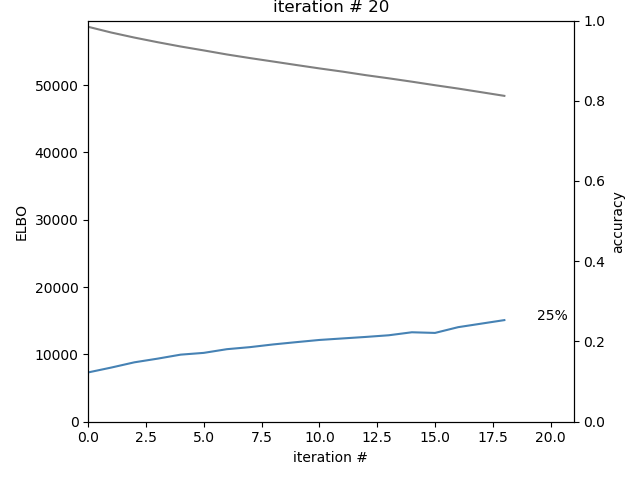

In [39]:
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)

import gpflow
import os

%matplotlib notebook

gpflow.reset_default_graph_and_session()

if plot_fit == True:
    
    import TRANSPIRE.visualization.training_monitor
    import matplotlib.pyplot as plt
    
    # for tracking fitting progress
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax_2 = ax.twinx()

for n_induce, kern_func in possible_hyperparams:
    
    # make a new directory for the models denoting the model architecture
    hyper_dir = os.path.join(base_dir, 'n={}_kernel={}'.format(n_induce, str(kern_func).split('.')[-1].strip("'>")))
    
    if not os.path.exists(hyper_dir):
        os.mkdir(hyper_dir)
    
    # build and fit a model for each fold of training data
    for k, X_train in training_data.groupby('fold'):
        
        # check if a file already exists (useful if you want to pause and resume training)
        if not k in [int(f.split('_')[-1]) for f in os.listdir(hyper_dir)]: 
        
            ax.clear()
            ax_2.clear()

            X = X_train.values
            y = X_train.index.get_level_values('label').map(mapping).values.reshape(-1, 1) # encode labels
            Z = Z_induce[n_induce][k] # set of inducing points already pre-calculated
            
            # define kernel function (with noise kernel added)
            kernel = kern_func(X.shape[1], ARD=True) + gpflow.kernels.White(X.shape[1], variance=1)
            
            # parameters required to build model
            model_params = {
                
                'Z': Z, # if Z is omitted from this dict, KMeans will be used to find n_inducing points during moldel generation
                'n_induce': n_induce, # only really required if Z is omitted
                'kernel': kernel,
            }
            
            # build the SVGP model
            m = TRANSPIRE.training.training.build_model(X, y, **model_params)

            # allow the optimizer to train both inducing points and the noise level (optional...one or more may be set to false--up to user-discresssion)
            m.feature.Z.trainable = True
            m.kern.kernels[1].trainable = True

            session = gpflow.get_default_session()
            
            if plot_fit == True:
                
                window = max(1, int(maxiter/50))
                tracker = TRANSPIRE.visualization.training_monitor.ProgressTracker(m, X, y)
                plotter = TRANSPIRE.visualization.training_monitor.ProgressPlotter(fig, ax, ax_2, maxiter, m.compute_log_likelihood(X)*-1, window)
                callback = TRANSPIRE.visualization.training_monitor.CustomCallback(tracker, plotter)

                opt = gpflow.training.AdamOptimizer(learning_rate=learning_rate)
                opt.minimize(m, maxiter=maxiter, step_callback=callback.update)
                
            else:
                
                opt = gpflow.training.AdamOptimizer(learning_rate=learning_rate)
                opt.minimize(m, maxiter=maxiter)

            # save the optimized model 
            m.anchor(session)
            gpflow.saver.Saver().save(os.path.join(hyper_dir, 'ELBO={:.0f}_{}'.format(m.compute_log_likelihood(X), k)), m)
            
            # this line is EXTREMELY IMPORTANT to prevent the tensorflow graph from continuing to grow call-after-call
            gpflow.reset_default_graph_and_session()     

#### 8. Evaluate each model on the validation data

In [42]:
results = {}

eval_limit = 10000 # max number of samples to evaluate at once (conserve RAM usage)
n_chunks = int(np.ceil(X_validate_mean.shape[0]/eval_limit))

for n_induce, kern_func in possible_hyperparams:
    
    hyper_dir = os.path.join(base_dir, 'n={}_kernel={}'.format(n_induce, str(kern_func).split('.')[-1].strip("'>")))
    
    if not os.path.exists(hyper_dir):
        
       raise FileNotFoundError()
    
    # iterate through files (e.g. models) in the directory
    for file in os.listdir(hyper_dir):
        
        fold = file.split('_')[-1]
        key = (n_induce, str(kern_func).split('.')[-1].strip("'>"), fold)
        
        print(key, end='   ')

        # load the optimized model from its directory
        m = gpflow.saver.Saver().load(os.path.join(hyper_dir, file))
        
        # iterate through the validation partition and evaluate model performance, save results in a dataframe
        means = []
        
        for i, arr in enumerate(np.array_split(X_validate_mean, n_chunks)):
            means.append(pd.DataFrame(m.predict_y(arr.values)[0], index=arr.index))
            print(i, end= ' ')
        
        # this line is EXTREMELY IMPORTANT to prevent the tensorflow graph from continuing to grow call-after-call
        gpflow.reset_default_graph_and_session()
        
        # combine results into a single dataframe
        means = pd.concat(means)
        
        # compute metrics to evaluate performance....
        results[key] = TRANSPIRE.training.performance.eval_report(means, mapping, mapping_r)
        
        print()

# combine results into a single dataframe
results = pd.concat({k:pd.concat(results[k]) for k in results}, names = ['n induce', 'kernel', 'fold', 'type of metric', 'metric'])

# save results
results.to_frame().to_csv(os.path.join(base_dir, 'hyperparameter_opt_results.csv'))

(1, 'SquaredExponential', '2')   0 1 2 3 4 5 (1, 'SquaredExponential', '5')   0 1 2 3 4 5 (1, 'SquaredExponential', '1')   0 1 2 3 4 5 (1, 'SquaredExponential', '4')   0 1 2 3 4 5 (1, 'SquaredExponential', '3')   0 1 2 3 4 5 (2, 'SquaredExponential', '1')   0 1 2 3 4 5 (2, 'SquaredExponential', '5')   0 1 2 3 4 5 (2, 'SquaredExponential', '4')   0 1 2 3 4 5 (2, 'SquaredExponential', '3')   0 1 2 3 4 5 (2, 'SquaredExponential', '2')   0 1 2 3 4 5 (3, 'SquaredExponential', '3')   0 1 2 3 4 5 (3, 'SquaredExponential', '1')   0 1 2 3 4 5 (3, 'SquaredExponential', '5')   0 1 2 3 4 5 (3, 'SquaredExponential', '4')   0 1 2 3 4 5 (3, 'SquaredExponential', '2')   0 1 2 3 4 5 

#### 9. Visualize the results and determine optimal hyperparameters

The cell below will plot two different kinds of metrics to help you decide what hyperparameters are the best. Note that the best F1 score is 1.0 and the worst F1 score is 0.0. On the other hand, the best loss is 0.0. In the binary classification setting, a classifier that is uninformative (e.g. no better than chance) will have a loss of >=0.7. In the multi-class case, an uninformative classifier will yield loss >= -log(1/M) where M is the total number of classes. 

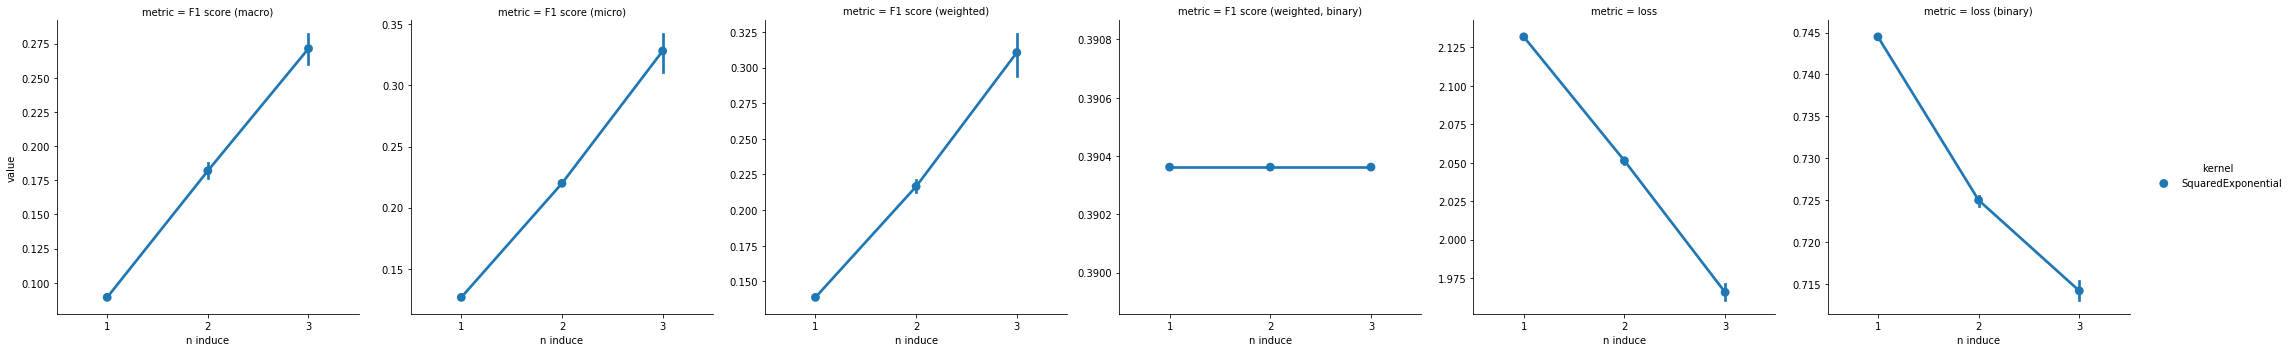

In [52]:
import seaborn as sns

%matplotlib inline

temp = results.unstack('type of metric')['singular metrics'].dropna()
sns.catplot(data=temp.reset_index().melt(temp.index.names), col='metric', hue='kernel', sharey=False, x='n induce', y='value', kind='point')

plt.show()

You can now take your chosen hyperparameters forward for final model fitting

In [54]:
n_limit = X_train_validate.groupby(['condition_A', 'condition_B']).apply(lambda y: y.groupby('label').size().min()*imbal_limit)


In [56]:
TRANSPIRE.utils.sample_balanced

<function TRANSPIRE.utils.sample_balanced(X, n_limit, n_folds, random_state=17)>

Creating balanced training partitions (this may take a while).... done
Creating balanced training partitions (this may take a while).... done
Creating balanced training partitions (this may take a while).... done
Creating balanced training partitions (this may take a while).... done
Creating balanced training partitions (this may take a while).... done
Creating balanced training partitions (this may take a while).... done
Creating balanced training partitions (this may take a while).... done
Creating balanced training partitions (this may take a while).... done
Creating balanced training partitions (this may take a while).... done
Creating balanced training partitions (this may take a while).... done
Creating balanced training partitions (this may take a while).... done
Creating balanced training partitions (this may take a while).... done
Creating balanced training partitions (this may take a while).... done
Creating balanced training partitions (this may take a while).... done
Creati

1  \
condition_A condition_B    fold label                      accession_A gene name_A localization_A condition_A accession_B gene name_B localization_B condition_B                
Mock 12 R1  Infected 12 R1 1    Mito/Perox to Mito/Perox   P55084      HADHB       Mito/Perox     Mock 12 R1  P30049      ATP5F1D     Mito/Perox     Infected 12 R1  0.518956   
                                                           P82673      MRPS35      Mito/Perox     Mock 12 R1  O95140      MFN2        Mito/Perox     Infected 12 R1  0.704877   
                                                           P51398      DAP3        Mito/Perox     Mock 12 R1  Q9BYD6      MRPL1       Mito/Perox     Infected 12 R1  0.707558   
                                                           Q96I59      NARS2       Mito/Perox     Mock 12 R1  P30405      PPIF        Mito/Perox     Infected 12 R1  0.679081   
                                                           Q9Y6N5      SQOR        Mito/Perox     Mock 12 R1  Q7L0Y3      TRMT10C     Mito/Perox     Infected 12 R1  0.592976   
...                                                                                                                                                                       ...   
Mock 72 R3  Infected 72 R3 5    Organellear to Organellear Q6UVY6      MOXD1       Organellear    Mock 72 R3  Q9NWM8      FKBP14      Organellear    Infected 72 R3  0.397537   
                                                           P23284      PPIB        Organellear    Mock 72 R3  Q08357      SLC20A2     Organellear    Infected 72 R3  0.334995   
                                                           P07602      PSAP        Organellear    Mock 72 R3  O00767      SCD         Organellear    Infected 72 R3  0.439297   
                                                           Q9Y5M8      SRPRB       Organellear    Mock 72 R3  Q6PIU2      NCEH1       Organellear    Infected 72 R3  0.452194   
                                                           Q8N4A0      GALNT4      Organellear    Mock 72 R3  Q7Z2K8      GPRIN1      Organellear    Infected 72 R3  0.788072   

                                                                                                                                                                            2  \
condition_A condition_B    fold label                      accession_A gene name_A localization_A condition_A accession_B gene name_B localization_B condition_B                
Mock 12 R1  Infected 12 R1 1    Mito/Perox to Mito/Perox   P55084      HADHB       Mito/Perox     Mock 12 R1  P30049      ATP5F1D     Mito/Perox     Infected 12 R1  0.341312   
                                                           P82673      MRPS35      Mito/Perox     Mock 12 R1  O95140      MFN2        Mito/Perox     Infected 12 R1  0.229181   
                                                           P51398      DAP3        Mito/Perox     Mock 12 R1  Q9BYD6      MRPL1       Mito/Perox     Infected 12 R1  0.235949   
                                                           Q96I59      NARS2       Mito/Perox     Mock 12 R1  P30405      PPIF        Mito/Perox     Infected 12 R1  0.276017   
                                                           Q9Y6N5      SQOR        Mito/Perox     Mock 12 R1  Q7L0Y3      TRMT10C     Mito/Perox     Infected 12 R1  0.310357   
...                                                                                                                                                                       ...   
Mock 72 R3  Infected 72 R3 5    Organellear to Organellear Q6UVY6      MOXD1       Organellear    Mock 72 R3  Q9NWM8      FKBP14      Organellear    Infected 72 R3  0.111936   
                                                           P23284      PPIB        Organellear    Mock 72 R3  Q08357      SLC20A2     Organellear    Infected 72 R3  0.373222   
                                                           P07602      PSAP        Organellear    Mo